# Demostrates Sampling Intrinsic Binary Parameters from GWPopulation Populations
## Written by Storm Colloms

In [1]:
import gwpopulation
from gwpopulation.models.redshift import PowerLawRedshift
from bilby.core.result import read_in_result
from scipy.interpolate import interp1d
import numpy as np
import deepdish as dd
import matplotlib.pyplot as plt

In [2]:
#requires gwpopulation>=0.6.3,<0.7
gwpopulation.utils.get_version_information()

'0.6.3:'

In [3]:
#gwpopulation requires numpy>=1.20.0,<1.24.0
np.__version__

'1.21.0'

## Loading in Hyperposterior samples from GWTC-3 data release PowerLawPlusPeak model

In [4]:
PP_path = '../GWTC-3-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json'
PP_result = read_in_result(PP_path)

In [5]:
print("run label: ", PP_result.label)

run label:  o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift


In [6]:
PP_hyperposterior_samples = PP_result.posterior.copy() # making a copy is best practice here so you don't accidentally modify things in-place
PP_hyperposterior_samples

,alpha,beta,mmax,mmin,lam,mpp,sigpp,delta_m,mu_chi,sigma_chi,...,lamb,amax,log_likelihood,log_prior,selection,pdet_n_effective,surveyed_hypervolume,log_10_rate,rate,min_event_n_effective
0,3.476035,1.192781,91.137635,3.335027,0.045152,32.019619,7.361617,5.502380,0.430299,0.037676,...,0.593878,1.0,86.219165,-20.158271,0.001980,5600.884717,1102.923927,1.539321,34.619495,184.210871
1,2.843807,0.551632,92.336309,3.455594,0.099132,21.146326,9.635711,3.504334,0.229716,0.027052,...,3.899003,1.0,88.795439,-20.158271,0.000176,7628.305892,24548.963167,1.203419,15.974191,91.831207
2,4.127894,1.910420,99.382743,4.114949,0.058528,26.304442,9.105968,4.430823,0.297703,0.036759,...,-0.096742,1.0,89.598445,-20.158271,0.002577,4734.966457,617.064144,1.681428,48.020645,94.982019
3,4.512565,1.291055,98.845047,2.963035,0.007879,32.267134,9.914114,9.800366,0.378698,0.052658,...,3.511903,1.0,90.035214,-20.158271,0.000295,5654.797132,16703.390755,1.146385,14.008291,289.936772
4,2.772482,0.149371,94.491001,5.138160,0.035747,30.469008,8.569162,3.361789,0.336149,0.034270,...,2.514446,1.0,90.339131,-20.158271,0.000582,8247.427572,6336.065138,1.302851,20.084052,261.964627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11179,3.388853,1.075150,89.768520,4.684262,0.030388,35.727936,3.478996,5.246642,0.244086,0.027675,...,2.733047,1.0,107.871029,-20.158271,0.000525,3796.539977,7811.787060,1.235183,17.186329,71.639539
11180,3.684463,1.539779,81.785901,5.327478,0.030328,34.102957,3.505780,5.133147,0.251205,0.033394,...,3.171738,1.0,107.877236,-20.158271,0.000377,4006.532961,11954.783380,1.175202,14.969305,72.109121
11181,3.684463,1.539779,81.785901,5.327478,0.030328,34.102957,3.505780,5.133147,0.251205,0.033394,...,3.171738,1.0,107.877236,-20.158271,0.000377,4006.532961,11954.783380,1.169904,14.787819,72.109121
11182,3.573136,0.627634,88.689645,5.303211,0.029184,34.600418,3.531467,4.342366,0.229689,0.032670,...,3.456785,1.0,107.909312,-20.158271,0.000266,3745.787380,15818.169705,1.239911,17.374440,73.194989


In [5]:
PP_hyperposterior_samples.keys()

Index(['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective'],
      dtype='object')

## Generating m_1 model from hyperposterior sample using two_componant_single function from gwpopulation - does not have smoothing

In [8]:
def gen_PLPP_model(mass, q, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """
    param_dict = {'mass_1':mass, 'mass_ratio':q}

    alpha = hyperpost_samp['alpha']
    beta = hyperpost_samp['beta']
    mmin = hyperpost_samp['mmin']
    mmax = hyperpost_samp['mmax']
    lam = hyperpost_samp['lam']
    mpp = hyperpost_samp['mpp']
    sigpp = hyperpost_samp['sigpp']
    break_fraction = hyperpost_samp['delta_m']

    return gwpopulation.models.mass.two_component_single(mass, alpha, mmin, mmax, lam, \
        mpp, sigpp)


In [28]:
masses= np.linspace(2.,100.)
qs= np.linspace(0.,1.)
PLPP = gen_PLPP_model(masses, qs, PP_hyperposterior_samples.iloc[7900])

/tmp/ipykernel_225674/3626844484.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-5,0)


(1e-05, 84.8104267973575)

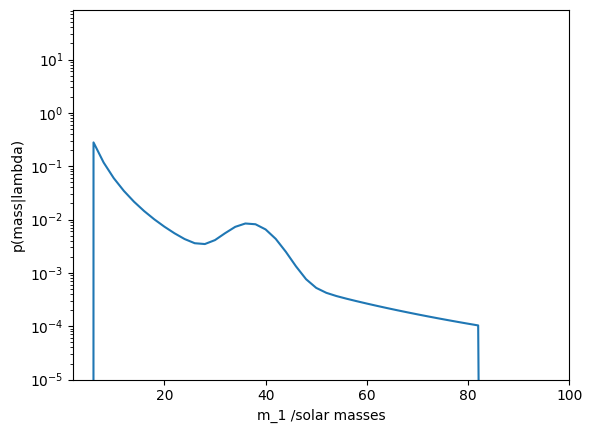

In [29]:
plt.plot(masses, PLPP)
plt.xlabel('m_1 /solar masses')
plt.ylabel('p(mass|lambda)')
plt.yscale('log')
plt.xlim(2,100)
plt.ylim(1e-5,0)

## Generating m_1 model from SinglePeakSmoothedMassDistribution GWPopulation class - has smoothing

In [37]:
def gen_mass_model(mass, q, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """
    param_dict = {'mass_1':mass, 'mass_ratio':q}

    alpha = hyperpost_samp['alpha']
    beta = hyperpost_samp['beta']
    mmin = hyperpost_samp['mmin']
    mmax = hyperpost_samp['mmax']
    lam = hyperpost_samp['lam']
    mpp = hyperpost_samp['mpp']
    sigpp = hyperpost_samp['sigpp']
    delta_m = hyperpost_samp['delta_m']

    mass_model = gwpopulation.models.mass.SinglePeakSmoothedMassDistribution()
    smoothing= mass_model.smoothing(mass, mmin=mmin, mmax=mmax, delta_m=delta_m)

    return smoothing*mass_model.p_m1(param_dict, **{'alpha':alpha, 'mmin':mmin, 'mmax':mmax, 'lam':lam, \
        'mpp':mpp, 'sigpp':sigpp})


In [92]:
mmin = PP_hyperposterior_samples.iloc[7900]['mmin']
mmax =PP_hyperposterior_samples.iloc[7900]['mmax']

masses= np.linspace(mmin,100.,1000)
qs= np.linspace(0.,1.,1000)
PLPP = gen_mass_model(masses, qs, PP_hyperposterior_samples.iloc[7900])
#PLPP_scratch = gen_mass_model_scratch(masses, qs, PP_hyperposterior_samples.iloc[7900])

/data/wiay/2297403c/conda_envs/GWTC-3-population/lib/python3.9/site-packages/gwpopulation/models/mass.py:552: RuntimeWarning: divide by zero encountered in true_divide
  delta_m / shifted_mass + delta_m / (shifted_mass - delta_m)


/tmp/ipykernel_64362/3249031581.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-5,0)


(1e-05, 0.5402581425662465)

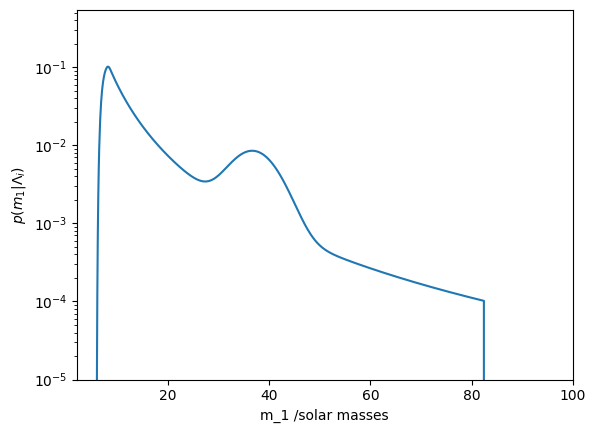

In [93]:
plt.plot(masses, PLPP)
#plt.plot(masses, PLPP_scratch)
plt.xlabel('m_1 /solar masses')
plt.ylabel(r'$p(m_1|\Lambda_i)$')
plt.yscale('log')
plt.xlim(2,100)
plt.ylim(1e-5,0)

In [31]:
from gwpopulation.cupy_utils import trapz, xp

def smoothing(masses, mmin, mmax, delta_m):
        """
        Apply a one sided window between mmin and mmin + delta_m to the
        mass pdf.

        The upper cut off is a step function,
        the lower cutoff is a logistic rise over delta_m solar masses.

        See T&T18 Eqs 7-8
        Note that there is a sign error in that paper.

        S = (f(m - mmin, delta_m) + 1)^{-1}
        f(m') = delta_m / m' + delta_m / (m' - delta_m)

        See also, https://en.wikipedia.org/wiki/Window_function#Planck-taper_window
        """
        window = xp.ones_like(masses)
        if delta_m > 0.0:
            smoothing_region = (masses >= mmin) & (masses < (mmin + delta_m))
            shifted_mass = masses[smoothing_region] - mmin
            if shifted_mass.size:
                exponent = xp.nan_to_num(
                    delta_m / shifted_mass + delta_m / (shifted_mass - delta_m)
                )
                window[smoothing_region] = 1 / (xp.exp(exponent) + 1)
        window[(masses < mmin) | (masses > mmax)] = 0
        return window

In [27]:
def gen_mass_model_scratch(mass, q, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """
    param_dict = {'mass_1':mass, 'mass_ratio':q}

    alpha = hyperpost_samp['alpha']
    beta = hyperpost_samp['beta']
    mmin = hyperpost_samp['mmin']
    mmax = hyperpost_samp['mmax']
    lam = hyperpost_samp['lam']
    mpp = hyperpost_samp['mpp']
    sigpp = hyperpost_samp['sigpp']
    delta_m = hyperpost_samp['delta_m']

    powerlaw = gwpopulation.utils.powerlaw(mass, alpha=-alpha, high=mmax, low=mmin)
    peak = gwpopulation.utils.truncnorm(mass, mu=mpp, sigma=sigpp, high=100, low=mmin)
    smoot= smoothing(mass, mmin=mmin, mmax=mmax, delta_m=delta_m)
    print(smoot)

    return smoot*((1 - lam) * powerlaw + lam * peak)

## Integrating p_m1 distribution

/tmp/ipykernel_64362/208152778.py:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-5,0)


(1e-05, 0.8545966367660358)

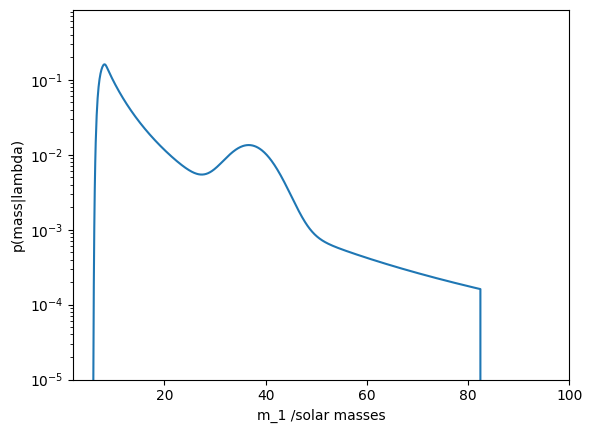

In [49]:
#normalising
p_m1 = PLPP/np.trapz(PLPP,masses)
plt.plot(masses, p_m1)
plt.xlabel('m_1 /solar masses')
plt.ylabel('p(mass|lambda)')
plt.yscale('log')
plt.xlim(2,100)
plt.ylim(1e-5,0)

In [29]:
np.trapz(PLPP,masses)

0.9999994547652373

## Checking distribution against PPD

In [45]:
mass_PP_path = '../GWTC-3-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
with open(mass_PP_path, 'r') as _data:
    _data = dd.io.load(mass_PP_path)
    print(_data.keys())
    print(_data['lines'].keys())

dict_keys(['injected', 'lines', 'ppd'])
dict_keys(['mass_1', 'mass_ratio'])


In [52]:
def mass_spectrum_plot(filenames, limits, labels):
    """
    Generates a plot of the PPD and X% credible region for the mass distribution,
    where X=limits[1]-limits[0]
    """
    mass_1 = np.linspace(2, 100, 1000)
    mass_ratio = np.linspace(0.1, 1, 500)
    mass_1_grid, mass_ratio_grid = np.meshgrid(mass_1, mass_ratio)
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    
    # load in the traces. 
    # Each entry in lines is p(m1 | Lambda_i) or p(q | Lambda_i)
    # where Lambda_i is a single draw from the hyperposterior
    # The ppd is a 2D object defined in m1 and q
    for filename, label in zip(filenames, labels):
        with open(filename, 'r') as _data:
            _data = dd.io.load(filename)
            lines = _data["lines"]
            ppd = _data["ppd"]

        # marginalize over q to get the ppd in terms of m1 only
        mass_1_ppd = np.trapz(ppd, mass_ratio, axis=0)
        mass_1_ppd /= np.trapz(mass_1_ppd, mass_1)
        # marginalize over m1 to get the ppd in terms of q only
        mass_ratio_ppd = np.trapz(ppd, mass_1, axis=-1)
        mass_ratio_ppd /= np.trapz(mass_ratio_ppd, mass_ratio)

        # plot the PPD as a solid line
        axs[0].semilogy(mass_1, mass_1_ppd, label=label)
        axs[0].semilogy(masses, p_m1)
        # plot the CIs as a filled interval
        axs[0].fill_between(
            mass_1,
            np.percentile(lines["mass_1"], limits[0], axis=0),
            np.percentile(lines["mass_1"], limits[1], axis=0),
            alpha=0.5,
        )
        axs[1].semilogy(mass_ratio, mass_ratio_ppd)
        axs[1].fill_between(
            mass_ratio,
            np.percentile(lines["mass_ratio"], limits[0], axis=0),
            np.percentile(lines["mass_ratio"], limits[1], axis=0),
            alpha=0.5,
        )
    axs[0].set_xlim(2, 100)
    axs[0].set_ylim(1e-3, 10)
    axs[0].set_xlabel("$m_{1}$ [$M_{\\odot}$]")
    axs[0].legend(loc="best")
    ylabel = "$\\frac{d\\mathcal{R}}{dm_{1}}$ [Gpc$^{-3}$yr$^{-1}M_{\\odot}^{-1}$]"
    axs[0].set_ylabel(ylabel)
    axs[1].set_xlim(0.1, 1)
    axs[1].set_ylim(1e-2, 200)
    axs[1].set_xlabel("$q$")
    ylabel = "$\\frac{d\\mathcal{R}}{dq}$ [Gpc$^{-3}$yr$^{-1}$]"
    axs[1].set_ylabel(ylabel)
    plt.tight_layout()
    return fig

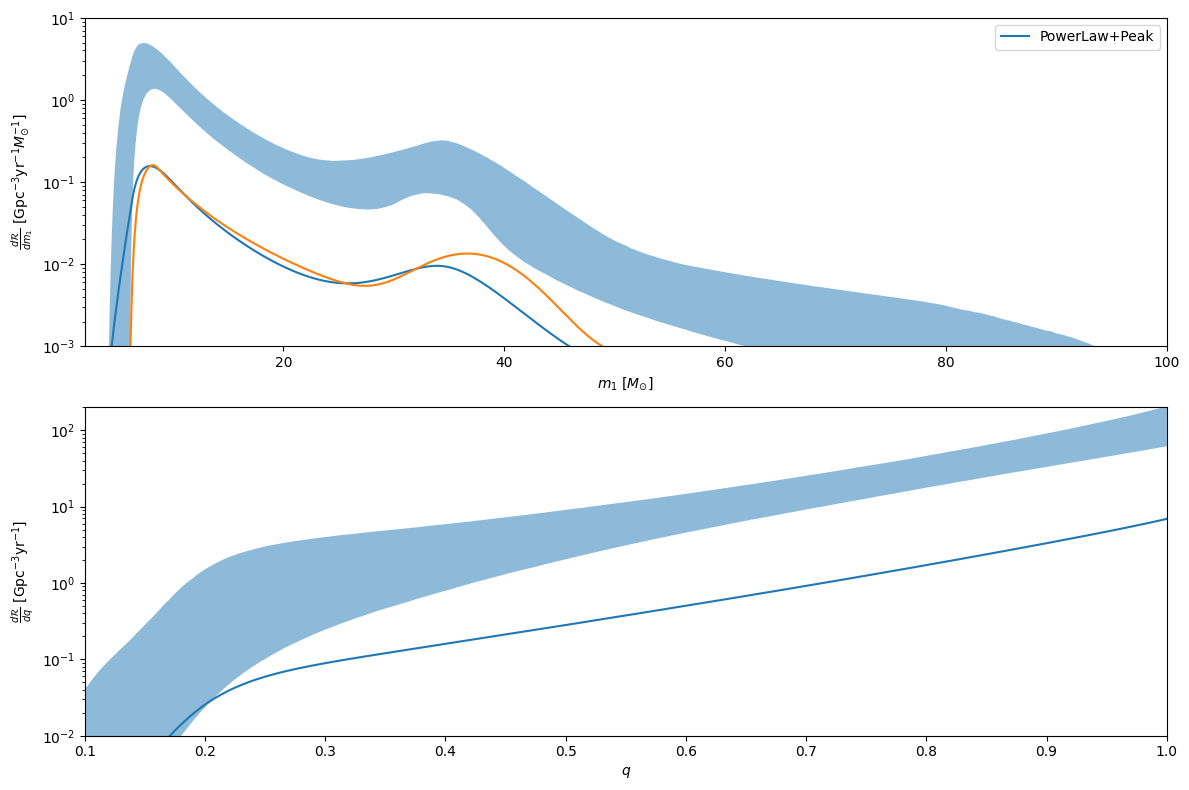

In [53]:
fig = mass_spectrum_plot([mass_PP_path], limits=[5,95], labels=['PowerLaw+Peak'])


## Returning mass ratio distribution from SinglePeakSmoothedMassDistribution

In [87]:
def gen_q_model(mass, q, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """
    param_dict = {'mass_1':mass, 'mass_ratio':q}

    beta = hyperpost_samp['beta']
    mmin = hyperpost_samp['mmin']
    delta_m = hyperpost_samp['delta_m']

    q_model = gwpopulation.models.mass.SinglePeakSmoothedMassDistribution()
    PL = gwpopulation.utils.powerlaw(param_dict["mass_ratio"], beta, 1, mmin / param_dict["mass_1"])
    p_q = q_model.p_q(param_dict, beta, mmin, delta_m)/np.trapz(q_model.p_q(param_dict, beta, mmin, delta_m),q)
    smoothing = q_model.smoothing(param_dict["mass_1"] * param_dict["mass_ratio"], mmin=mmin, mmax=param_dict["mass_1"], delta_m=delta_m)

    return PL, smoothing, p_q


In [88]:
masses= np.array([50.])
qs= np.linspace(0.,1.,1000)
PL, smoothing, PLQ = gen_q_model(masses, qs, PP_hyperposterior_samples.iloc[1])

/data/wiay/2297403c/conda_envs/GWTC-3-population/lib/python3.9/site-packages/gwpopulation/models/mass.py:554: RuntimeWarning: overflow encountered in exp
  window[smoothing_region] = 1 / (xp.exp(exponent) + 1)


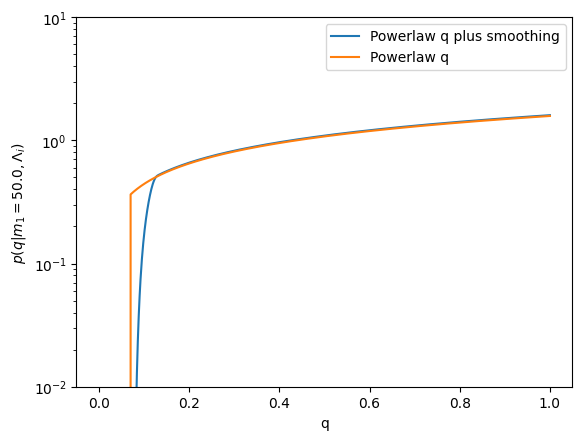

In [91]:
plt.plot(qs, PLQ, label="Powerlaw q plus smoothing")
plt.plot(qs, PL, label="Powerlaw q")
plt.xlabel('q')
plt.ylabel(fr'$p(q|m_1={masses[0]}, \Lambda_i)$')
plt.yscale('log')
plt.ylim(1e-2,1e1)
plt.legend()

## Generating redshift model from gwpopulation PowerLawRedshift

In [43]:
def gen_z_model(z, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """

    lamb = hyperpost_samp['lamb']
    param_dict = {'redshift':z}

    z_model = gwpopulation.models.redshift.PowerLawRedshift()

    return z_model.probability(param_dict, **{'lamb':lamb})

In [44]:
zs= np.linspace(0.,2.3,1000)
PLZ = gen_z_model(zs, PP_hyperposterior_samples.iloc[7900])

Text(0, 0.5, 'p(z|lambda)')

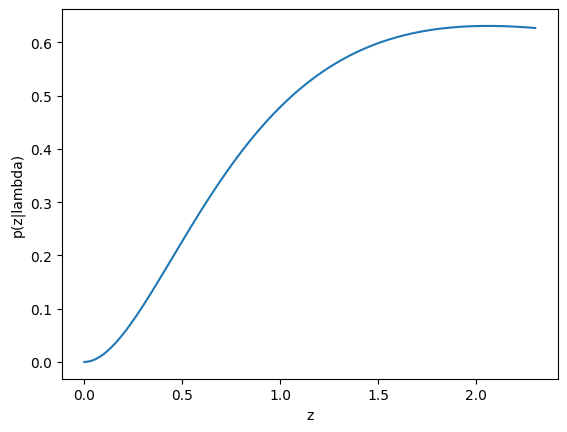

In [45]:
plt.plot(zs, PLZ)
plt.xlabel('z')
plt.ylabel('p(z|lambda)')
#plt.yscale('log')

In [46]:
np.trapz(PLZ, zs)

1.0000002113081576

## Generating spin models with iid_spin_magnitude_beta for spin magnitudes and iid_spin_orientation_gaussian_isotropic for spin tilts

In [47]:
def gen_spin_model(chi, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """

    amax = hyperpost_samp['amax']
    #notation is different in hyperposterior samples to gwpopulation/gwtc-3 pop paper:
    alpha_chi, beta_chi, amax = gwpopulation.conversions.mu_var_max_to_alpha_beta_max(hyperpost_samp['mu_chi'],hyperpost_samp['sigma_chi'], amax)

    param_dict = {'a_1':chi, 'a_2':chi}


    return gwpopulation.models.spin.iid_spin_magnitude_beta(param_dict, amax=amax, alpha_chi=alpha_chi, beta_chi=beta_chi)

In [48]:
chis= np.linspace(0.,1.,1000)
IID_spinmag = gen_spin_model(chis, PP_hyperposterior_samples.iloc[790])

/data/wiay/2297403c/conda_envs/GWTC-3-population/lib/python3.9/site-packages/gwpopulation/utils.py:38: RuntimeWarning: divide by zero encountered in log
  ln_beta = (alpha - 1) * xp.log(xx) + (beta - 1) * xp.log(scale - xx)


In [49]:
np.trapz(IID_spinmag, chis)

1.2844269808173807

Text(0, 0.5, 'p(chi_i|lambda)')

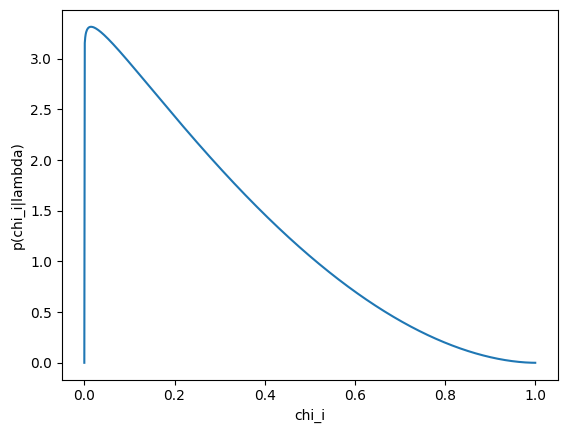

In [36]:
plt.plot(chis, IID_spinmag)
plt.xlabel('chi_i')
plt.ylabel('p(chi_i|lambda)')

In [51]:
def gen_spin_tilts(cos_tilt, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """

    xi_spin = hyperpost_samp['xi_spin']
    sigma_spin = hyperpost_samp['sigma_spin']

    param_dict = {'cos_tilt_1':cos_tilt, 'cos_tilt_2':cos_tilt}


    return gwpopulation.models.spin.iid_spin_orientation_gaussian_isotropic(param_dict, xi_spin, sigma_spin)

In [52]:
tilts= np.linspace(-1.,1.,1000)
IID_spintilts = gen_spin_tilts(tilts, PP_hyperposterior_samples.iloc[7900])

In [53]:
np.trapz(IID_spintilts, tilts)

0.5565656716328378

Text(0, 0.5, 'p(cos tilt|lambda)')

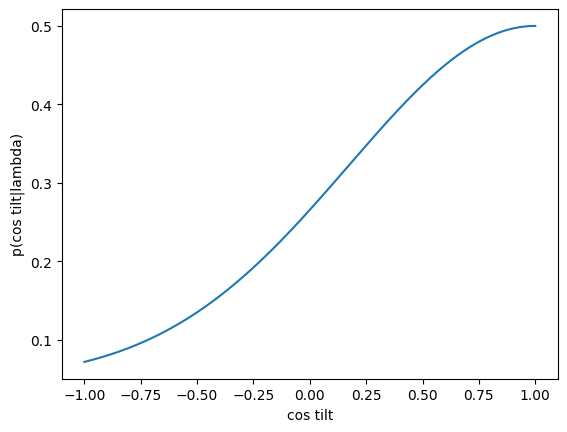

In [35]:
plt.plot(tilts, IID_spintilts)
plt.xlabel('cos tilt')
plt.ylabel('p(cos tilt|lambda)')

# Inverse CDF sampling

In [94]:
def sample_1D(distr, theta, N):
    rand = np.random.random(N)
    print(np.max(rand))
    theta, CDF_theta = CDF(distr, theta)
    samps = np.interp(rand, CDF_theta, theta)
    return samps
    

In [95]:
def CDF(distr, x):
    CDF = []
    for i in range(len(x)):
        CDF.append(np.trapz(distr[:i+1], x[:i+1]))
    return x, CDF

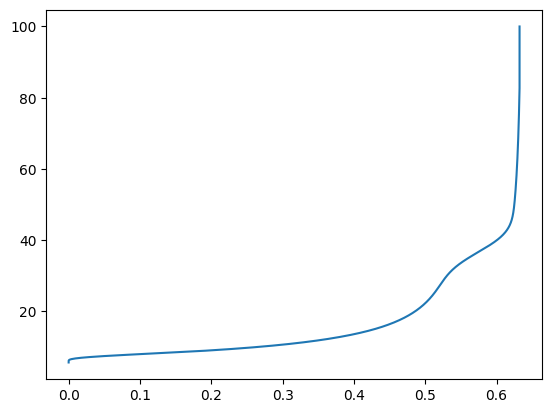

In [96]:
mass_CDF = CDF(PLPP, masses)
plt.plot(mass_CDF[1], mass_CDF[0])

In [97]:
np.interp(0.9, mass_CDF[1], mass_CDF[0])

100.0

In [13]:
m1 = sample_1D(PLPP, masses, 100000)

0.999997958226061


In [21]:
np.max(mass_CDF[1])

0.9999994547652374

In [22]:
mass_CDF[1][-1]

0.9999994547652373

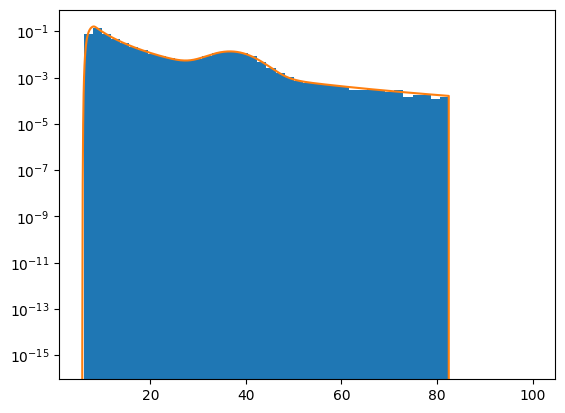

In [15]:
plt.hist(m1, density=True, bins=40)
plt.plot(masses, PLPP)
plt.yscale('log')